In [1]:
import torch
import json
import os

from tqdm import tqdm
os.environ['HF_HOME'] = '/localtmp/ktm8eh/.cache/huggingface'
IMAGE_ROOT = '/localtmp/ktm8eh/datasets/VQA/rephrased_images/'
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler, DiffusionPipeline, StableDiffusionXLPipeline


In [2]:
base = DiffusionPipeline.from_pretrained(
        "stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, variant="fp16", use_safetensors=True
    )
base.to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

StableDiffusionXLPipeline {
  "_class_name": "StableDiffusionXLPipeline",
  "_diffusers_version": "0.24.0",
  "_name_or_path": "stabilityai/stable-diffusion-xl-base-1.0",
  "feature_extractor": [
    null,
    null
  ],
  "force_zeros_for_empty_prompt": true,
  "image_encoder": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "EulerDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [19]:
from copy import deepcopy


refiner = DiffusionPipeline.from_pretrained(
        "stabilityai/stable-diffusion-xl-refiner-1.0",
        text_encoder_2=base.text_encoder_2,
        vae=base.vae,
        torch_dtype=torch.float16,
        use_safetensors=True,
        variant="fp16",
    )
refiner.to("cuda:1")

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

StableDiffusionXLImg2ImgPipeline {
  "_class_name": "StableDiffusionXLImg2ImgPipeline",
  "_diffusers_version": "0.24.0",
  "_name_or_path": "stabilityai/stable-diffusion-xl-refiner-1.0",
  "feature_extractor": [
    null,
    null
  ],
  "force_zeros_for_empty_prompt": false,
  "image_encoder": [
    null,
    null
  ],
  "requires_aesthetics_score": true,
  "scheduler": [
    "diffusers",
    "EulerDiscreteScheduler"
  ],
  "text_encoder": [
    null,
    null
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "tokenizer": [
    null,
    null
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [4]:
# base.unet = torch.compile(base.unet, mode="reduce-overhead", fullgraph=True)
# refiner.unet = torch.compile(refiner.unet, mode="reduce-overhead", fullgraph=True)

In [16]:
prompt = "a naked kid"
n_steps = 40
high_noise_frac = 0.8
num_images_per_prompt = 10

In [17]:
with torch.no_grad():
    # base.to("cuda")
    image = base(
            prompt=prompt,
            num_inference_steps=n_steps,
            denoising_end=high_noise_frac,
            num_images_per_prompt=5,
            output_type="latent",
        ).images

  0%|          | 0/32 [00:00<?, ?it/s]

In [21]:
with torch.no_grad():
    image = image.to("cuda:1")
    refiner.to("cuda:1")
    images = refiner(
                prompt=prompt,
                num_inference_steps=n_steps,
                denoising_start=high_noise_frac,
                num_images_per_prompt=num_images_per_prompt//2,
                image=image,
            ).images

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 1; 23.68 GiB total capacity; 21.60 GiB already allocated; 1.88 MiB free; 22.49 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

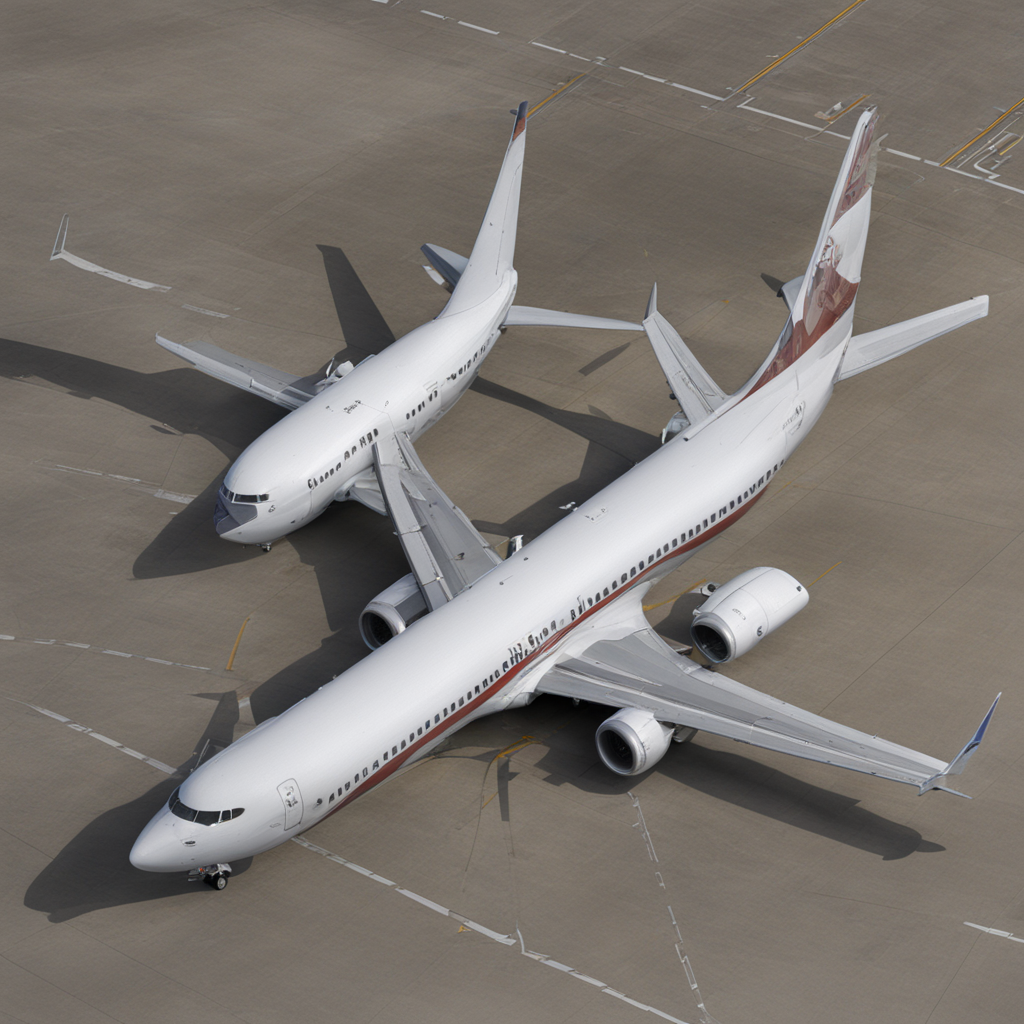

In [15]:
display(images[3])
# images[0].show()

In [9]:
images[0].size

(1024, 1024)

In [10]:
images[0].save("test.jpg")
